In [73]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
from pypfopt import BlackLittermanModel, risk_models, expected_returns
from pypfopt import EfficientFrontier, objective_functions
import warnings
warnings.filterwarnings('ignore')

In [74]:
np.random.seed(42)

In [75]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [76]:
dow30_tickers = [
    'AAPL', 'MSFT', 'AMGN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS',
     'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD',
    'MMM', 'MRK', 'NKE', 'PG', 'TRV', 'UNH',  'VZ', 'WBA', 'WMT'
]

In [77]:
print("Fetching historical data for Dow Jones 30...")
start_date = '2006-01-01'
end_date = '2024-01-01'

Fetching historical data for Dow Jones 30...


In [78]:
prices = yf.download(dow30_tickers, start=start_date, end=end_date)["Close"]
prices = prices.dropna()

[*********************100%***********************]  28 of 28 completed


In [79]:
prices

Ticker,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MMM,MRK,MSFT,NKE,PG,TRV,UNH,VZ,WBA,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2006-01-03,2.246551,55.568748,39.139187,50.119698,35.203171,8.485645,11.488683,28.028053,19.777195,94.820473,...,37.081547,15.721174,18.780910,8.359501,34.022327,28.941036,48.620518,10.203044,26.447041,10.321803
2006-01-04,2.253163,55.305992,38.758686,50.639103,36.098469,8.914387,11.752035,27.947407,19.444874,93.510780,...,36.894062,15.903589,18.871880,8.320599,34.085987,29.261978,48.738647,10.501951,25.625479,10.341900
2006-01-05,2.235431,54.503864,39.169048,50.041420,36.098469,8.936692,12.081224,27.605831,19.785299,93.473969,...,36.556568,15.927588,18.885864,8.371175,33.976017,29.545145,48.589001,10.622855,25.392401,10.201243
2006-01-06,2.293134,54.005974,39.303329,49.344154,36.817146,9.875960,12.357744,28.108698,20.052780,94.798393,...,36.856556,15.898790,18.829885,8.344913,33.941296,29.708771,49.542038,10.665380,25.270060,10.243661
2006-01-09,2.285620,54.614502,40.280697,48.931442,37.487099,9.548828,12.548669,27.966394,20.263521,95.938858,...,37.039360,16.158010,18.794905,8.461623,34.195984,29.721344,48.360584,10.709609,25.584700,10.205706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,192.192535,271.218292,182.338852,260.440002,283.368225,264.026459,47.863064,141.499283,90.202316,367.979218,...,85.087776,102.910149,370.375732,104.985359,140.019150,180.990509,506.513519,33.989986,24.237406,51.332783
2023-12-26,191.646545,270.970154,182.722076,262.790009,288.511383,263.907501,48.044613,142.773285,90.132942,368.907227,...,86.512161,102.843254,370.454865,104.965927,140.655243,182.247116,506.240936,33.980915,24.597919,51.254139
2023-12-27,191.745834,273.480377,183.802902,262.100006,290.941376,264.403168,48.197495,142.304901,89.568062,371.681732,...,87.016312,103.177696,369.871490,104.101089,140.770889,183.737503,508.927704,33.826790,24.625648,51.735844


In [80]:
market_caps = {}
for ticker in dow30_tickers:
    
    info = yf.Ticker(ticker).info
    market_caps[ticker] = info.get('marketCap', 100e9)  # Default to 100B if not available
    

print(f"Data fetched successfully. Shape: {prices.shape}")
print(f"Date range: {prices.index[0]} to {prices.index[-1]}")

Data fetched successfully. Shape: (4529, 28)
Date range: 2006-01-03 00:00:00 to 2023-12-29 00:00:00


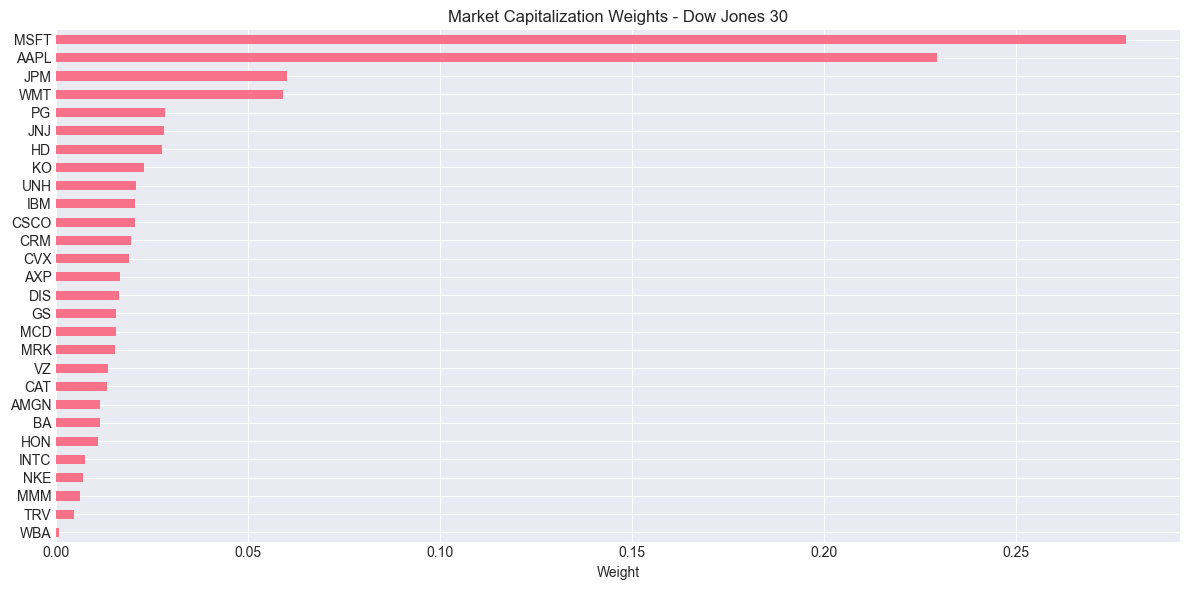

In [81]:
total_mcap = sum(market_caps.values())
market_weights = {ticker: mcap/total_mcap for ticker, mcap in market_caps.items()}
market_weights_series = pd.Series(market_weights)
# Visualize market weights
plt.figure(figsize=(12, 6))
market_weights_series.sort_values(ascending=True).plot(kind='barh')
plt.title('Market Capitalization Weights - Dow Jones 30')
plt.xlabel('Weight')
plt.tight_layout()
plt.show()

In [82]:
print("\nTop 10 stocks by market cap weight:")
print(market_weights_series.sort_values(ascending=False).head(10))


Top 10 stocks by market cap weight:
MSFT    0.278794
AAPL    0.229391
JPM     0.060153
WMT     0.059143
PG      0.028400
JNJ     0.027919
HD      0.027433
KO      0.022837
UNH     0.020876
IBM     0.020612
dtype: float64


In [83]:
def generate_bl_views(confidence):
    
    confidences = {'MSFT': np.float64(confidence), 'AAPL': np.float64(confidence)}
    
    views_dict = {'MSFT': np.float64(0.7), 'AAPL': np.float64(0.8)}
    
    return views_dict, confidences


In [85]:
returns = prices.pct_change().dropna()
sample_views, sample_confidences = generate_bl_views(0.75)
print("Sample views generated:")
for ticker, view in list(sample_views.items()):
    print(f"{ticker}: {view:.2%} (confidence: {sample_confidences[ticker]:.3f})")

Sample views generated:
MSFT: 70.00% (confidence: 0.750)
AAPL: 80.00% (confidence: 0.750)


In [86]:
sample_views

{'MSFT': np.float64(0.7), 'AAPL': np.float64(0.8)}

In [103]:
def construct_bl_portfolio(prices, market_caps, views_dict, confidences, tau=0.025):
    """
    Construct Black-Litterman optimized portfolio
    
    Parameters:
    - prices: DataFrame of prices
    - market_caps: Dictionary of market capitalizations
    - views_dict: Dictionary of views
    - confidences: Dictionary of view confidences
    - tau: Black-Litterman tau parameter
    
    Returns:
    - bl_weights: Dictionary of optimized weights
    """
    # Calculate expected returns and covariance
    returns = prices.pct_change().dropna()
    
    # Use exponentially-weighted covariance for more recent emphasis
    S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()

    #Turn confidences into a np.array
    confidences = np.array([confidences[ticker] for ticker in prices.columns if ticker in views_dict])
    
    # Initialize Black-Litterman model
    bl = BlackLittermanModel(cov_matrix = S, absolute_views=views_dict, pi="market", market_caps=market_caps, 
                            risk_aversion=2.5, tau=tau, omega='idzorek', view_confidences=confidences)
    
    # Get posterior estimates
    bl_returns = bl.bl_returns()
    bl_cov = bl.bl_cov()
    
    # Optimize portfolio
    ef = EfficientFrontier(bl_returns, bl_cov)
    #ef.add_constraint(lambda w: w >= 0)  # Long-only constraint
    ef.add_constraint(lambda w: w <= 0.45)  # Max 45% per position
    
    # Maximize Sharpe ratio
    ef.max_sharpe(risk_free_rate=0.04)
    
    # Get clean weights
    bl_weights = ef.clean_weights()
    
    return bl_weights

In [90]:
class PortfolioBacktest:
    """
    Comprehensive backtesting engine for portfolio strategies
    """
    
    def __init__(self, prices, initial_value=1000000, rebalance_freq='Q', 
                 transaction_cost=0.001):
        """
        Initialize backtesting engine
        
        Parameters:
        - prices: DataFrame of adjusted close prices
        - initial_value: Initial portfolio value
        - rebalance_freq: Rebalancing frequency ('M' for monthly, 'Q' for quarterly)
        - transaction_cost: Transaction cost as percentage of trade value
        """
        self.prices = prices
        self.returns = prices.pct_change().dropna()
        self.initial_value = initial_value
        self.rebalance_freq = rebalance_freq
        self.transaction_cost = transaction_cost
        
        # Results storage
        self.portfolio_values = {}
        self.weights_history = {}
        self.turnover_history = {}
        
    def run_backtest(self, strategy_name, weight_function, lookback_window=252, bl_confidence=0.75):
        """
        Run backtest for a given strategy
        
        Parameters:
        - strategy_name: Name of the strategy
        - weight_function: Function that returns weights given historical data
        - lookback_window: Number of days for historical window
        """
        # Initialize results
        portfolio_values = [self.initial_value]
        weights_history = []
        turnover_history = []
        dates = []
        
        # Get rebalancing dates
        rebalance_dates = pd.date_range(
            start=self.prices.index[lookback_window],
            end=self.prices.index[-1],
            freq=self.rebalance_freq
        )
        
        # Initial weights (equal weight to start)
        current_weights = pd.Series(1/len(self.prices.columns), 
                                   index=self.prices.columns)
        
        # Track portfolio composition
        holdings = current_weights * self.initial_value / self.prices.iloc[lookback_window]
        
        print(f"\nRunning backtest for {strategy_name}...")
        print(f"Rebalancing frequency: {self.rebalance_freq}")
        print(f"Number of rebalancing dates: {len(rebalance_dates)}")
        
        # Simulate through time
        for i in range(lookback_window + 1, len(self.prices)):
            current_date = self.prices.index[i]
            
            # Check if rebalancing date
            if current_date in rebalance_dates:
                # Get historical data
                hist_prices = self.prices.iloc[:i]
                
                # Calculate new weights
                new_weights = weight_function(hist_prices, bl_confidence)
                new_weights = pd.Series(new_weights)
                
                # Calculate turnover
                turnover = np.abs(new_weights - current_weights).sum()
                turnover_history.append(turnover)
                
                # Calculate current portfolio value
                current_value = (holdings * self.prices.iloc[i]).sum()
                
                # Apply transaction costs
                transaction_costs = current_value * self.transaction_cost * turnover
                current_value -= transaction_costs
                
                # Rebalance holdings
                holdings = new_weights * current_value / self.prices.iloc[i]
                current_weights = new_weights
                weights_history.append(new_weights.to_dict())
                
            # Calculate daily portfolio value
            portfolio_value = (holdings * self.prices.iloc[i]).sum()
            portfolio_values.append(portfolio_value)
            dates.append(current_date)
        
        # Store results
        self.portfolio_values[strategy_name] = pd.Series(
            portfolio_values[1:], index=dates
        )
        self.weights_history[strategy_name] = weights_history
        self.turnover_history[strategy_name] = turnover_history
        
        print(f"Backtest complete for {strategy_name}")
        print(f"Final value: ${portfolio_values[-1]:,.2f}")
        print(f"Total return: {(portfolio_values[-1]/self.initial_value - 1)*100:.2f}%")
        
        return self.portfolio_values[strategy_name]

In [101]:
def market_cap_weights(hist_prices, confidence):
    """Calculate market-cap weighted portfolio"""
    # Use global market_caps (in practice, these would be time-varying)
    total_mcap = sum(market_caps.values())
    weights = {ticker: market_caps.get(ticker, 0)/total_mcap 
               for ticker in hist_prices.columns}
    return weights

def equal_weights(hist_prices, confidence):
    """Calculate equal-weighted portfolio"""
    n_assets = len(hist_prices.columns)
    weights = {ticker: 1/n_assets for ticker in hist_prices.columns}
    return weights

def black_litterman_weights(hist_prices, confidence):
    """Calculate Black-Litterman optimized weights"""
    # Generate views based on recent data
    recent_returns = hist_prices.pct_change().dropna()
    views_dict, confidences = generate_bl_views(confidence)
    
    bl_weights = construct_bl_portfolio(
        hist_prices, market_caps, views_dict, confidences
    )
    return bl_weights
   

In [104]:
backtest = PortfolioBacktest(
    prices, 
    initial_value=1000000,
    rebalance_freq='Q',  # Quarterly rebalancing
    transaction_cost=0.01  # 1% transaction cost
)

# Run backtests for different strategies
strategies = {
    'Market-Cap Weighted': market_cap_weights,
    'Equal Weighted': equal_weights,
    'Black-Litterman': black_litterman_weights
}

confidenes = [0.25, 0.5, 0.75, 1]  # Example confidence levels for views

for confidence in confidenes:
    print(f"\nRunning backtests with confidence level: {confidence}")
    # Run each strategy with the specified confidence level
    for name, weight_func in strategies.items():
        backtest.run_backtest(name, weight_func, bl_confidence=confidence)


Running backtests with confidence level: 0.25

Running backtest for Market-Cap Weighted...
Rebalancing frequency: Q
Number of rebalancing dates: 67
Backtest complete for Market-Cap Weighted
Final value: $15,030,638.42
Total return: 1403.06%

Running backtest for Equal Weighted...
Rebalancing frequency: Q
Number of rebalancing dates: 67
Backtest complete for Equal Weighted
Final value: $7,540,639.13
Total return: 654.06%

Running backtest for Black-Litterman...
Rebalancing frequency: Q
Number of rebalancing dates: 67
Backtest complete for Black-Litterman
Final value: $22,632,678.59
Total return: 2163.27%

Running backtests with confidence level: 0.5

Running backtest for Market-Cap Weighted...
Rebalancing frequency: Q
Number of rebalancing dates: 67
Backtest complete for Market-Cap Weighted
Final value: $15,030,638.42
Total return: 1403.06%

Running backtest for Equal Weighted...
Rebalancing frequency: Q
Number of rebalancing dates: 67
Backtest complete for Equal Weighted
Final value: 

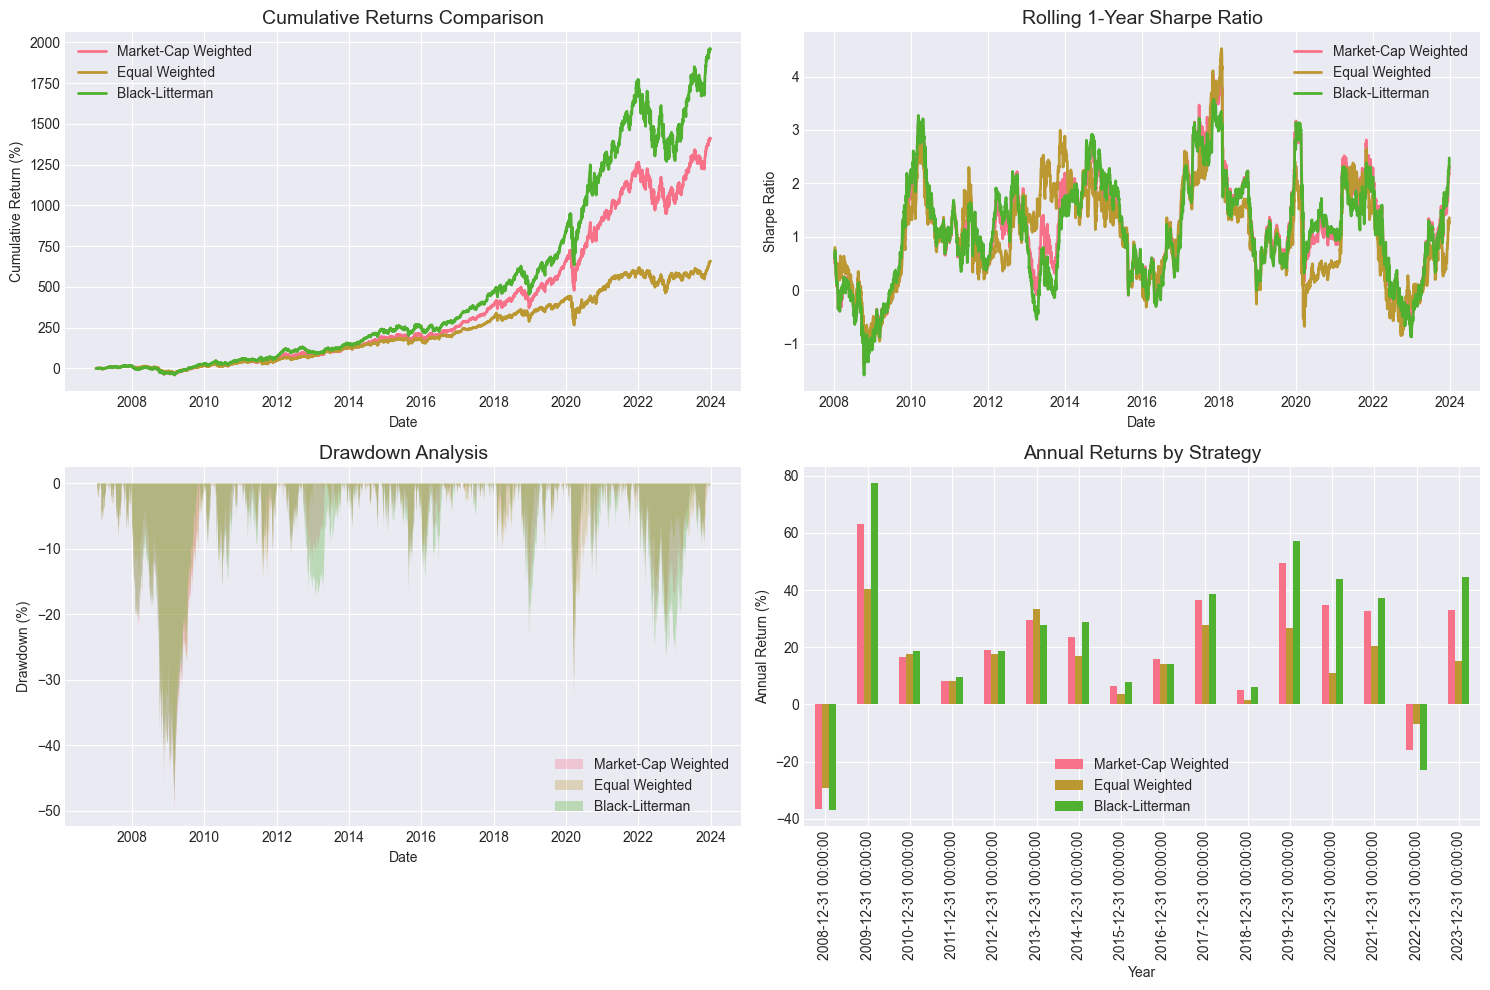

In [94]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Cumulative Returns
ax1 = axes[0, 0]
for strategy in backtest.portfolio_values:
    returns = (backtest.portfolio_values[strategy] / 
               backtest.portfolio_values[strategy].iloc[0] - 1) * 100
    ax1.plot(returns, label=strategy, linewidth=2)
ax1.set_title('Cumulative Returns Comparison', fontsize=14)
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative Return (%)')
ax1.legend()
ax1.grid(True)

# 2. Rolling Sharpe Ratio
ax2 = axes[0, 1]
window = 252  # 1-year rolling
for strategy in backtest.portfolio_values:
    daily_returns = backtest.portfolio_values[strategy].pct_change()
    rolling_sharpe = (daily_returns.rolling(window).mean() / 
                     daily_returns.rolling(window).std() * np.sqrt(252))
    ax2.plot(rolling_sharpe, label=strategy, linewidth=2)
ax2.set_title('Rolling 1-Year Sharpe Ratio', fontsize=14)
ax2.set_xlabel('Date')
ax2.set_ylabel('Sharpe Ratio')
ax2.legend()
ax2.grid(True)

# 3. Drawdown Analysis
ax3 = axes[1, 0]
for strategy in backtest.portfolio_values:
    # Calculate drawdown
    cum_returns = backtest.portfolio_values[strategy]
    running_max = cum_returns.expanding().max()
    drawdown = (cum_returns - running_max) / running_max * 100
    ax3.fill_between(drawdown.index, drawdown, 0, alpha=0.3, label=strategy)
ax3.set_title('Drawdown Analysis', fontsize=14)
ax3.set_xlabel('Date')
ax3.set_ylabel('Drawdown (%)')
ax3.legend()
ax3.grid(True)

# 4. Annual Returns Bar Chart
ax4 = axes[1, 1]
annual_returns = {}
for strategy in backtest.portfolio_values:
    values = backtest.portfolio_values[strategy]
    annual = values.resample('Y').last().pct_change() * 100
    annual_returns[strategy] = annual.dropna()

# Create DataFrame for grouped bar chart
annual_df = pd.DataFrame(annual_returns)
annual_df.plot(kind='bar', ax=ax4)
ax4.set_title('Annual Returns by Strategy', fontsize=14)
ax4.set_xlabel('Year')
ax4.set_ylabel('Annual Return (%)')
ax4.legend()
ax4.grid(True, axis='y')

plt.tight_layout()
plt.show()

In [95]:
def calculate_performance_metrics(portfolio_values, risk_free_rate=0.02):
    """Calculate comprehensive performance metrics"""
    # Daily returns
    daily_returns = portfolio_values.pct_change().dropna()
    
    # Annualized metrics
    annual_return = daily_returns.mean() * 252
    annual_vol = daily_returns.std() * np.sqrt(252)
    sharpe_ratio = (annual_return - risk_free_rate) / annual_vol
    
    # Drawdown metrics
    cum_returns = portfolio_values
    running_max = cum_returns.expanding().max()
    drawdown = (cum_returns - running_max) / running_max
    max_drawdown = drawdown.min()
    
    # Calmar ratio
    calmar_ratio = annual_return / abs(max_drawdown)
    
    # Win rate
    win_rate = (daily_returns > 0).mean()
    
    # Downside deviation
    downside_returns = daily_returns[daily_returns < 0]
    downside_dev = downside_returns.std() * np.sqrt(252)
    sortino_ratio = (annual_return - risk_free_rate) / downside_dev
    
    return {
        'Annual Return': f"{annual_return*100:.2f}%",
        'Annual Volatility': f"{annual_vol*100:.2f}%",
        'Sharpe Ratio': f"{sharpe_ratio:.3f}",
        'Sortino Ratio': f"{sortino_ratio:.3f}",
        'Max Drawdown': f"{max_drawdown*100:.2f}%",
        'Calmar Ratio': f"{calmar_ratio:.3f}",
        'Win Rate': f"{win_rate*100:.1f}%",
        'Total Return': f"{(portfolio_values.iloc[-1]/portfolio_values.iloc[0] - 1)*100:.2f}%"
    }

# Calculate metrics for all strategies
print("\n" + "="*60)
print("PERFORMANCE METRICS SUMMARY")
print("="*60)

metrics_df = pd.DataFrame()
for strategy in backtest.portfolio_values:
    metrics = calculate_performance_metrics(backtest.portfolio_values[strategy])
    metrics_df[strategy] = metrics

print(metrics_df)



PERFORMANCE METRICS SUMMARY
                  Market-Cap Weighted Equal Weighted Black-Litterman
Annual Return                  18.25%         13.81%          20.41%
Annual Volatility              21.15%         19.32%          22.72%
Sharpe Ratio                    0.768          0.611           0.810
Sortino Ratio                   0.982          0.757           1.078
Max Drawdown                  -49.89%        -45.92%         -48.70%
Calmar Ratio                    0.366          0.301           0.419
Win Rate                        55.4%          55.4%           54.6%
Total Return                 1411.53%        658.31%        1957.65%


<Figure size 1200x600 with 0 Axes>

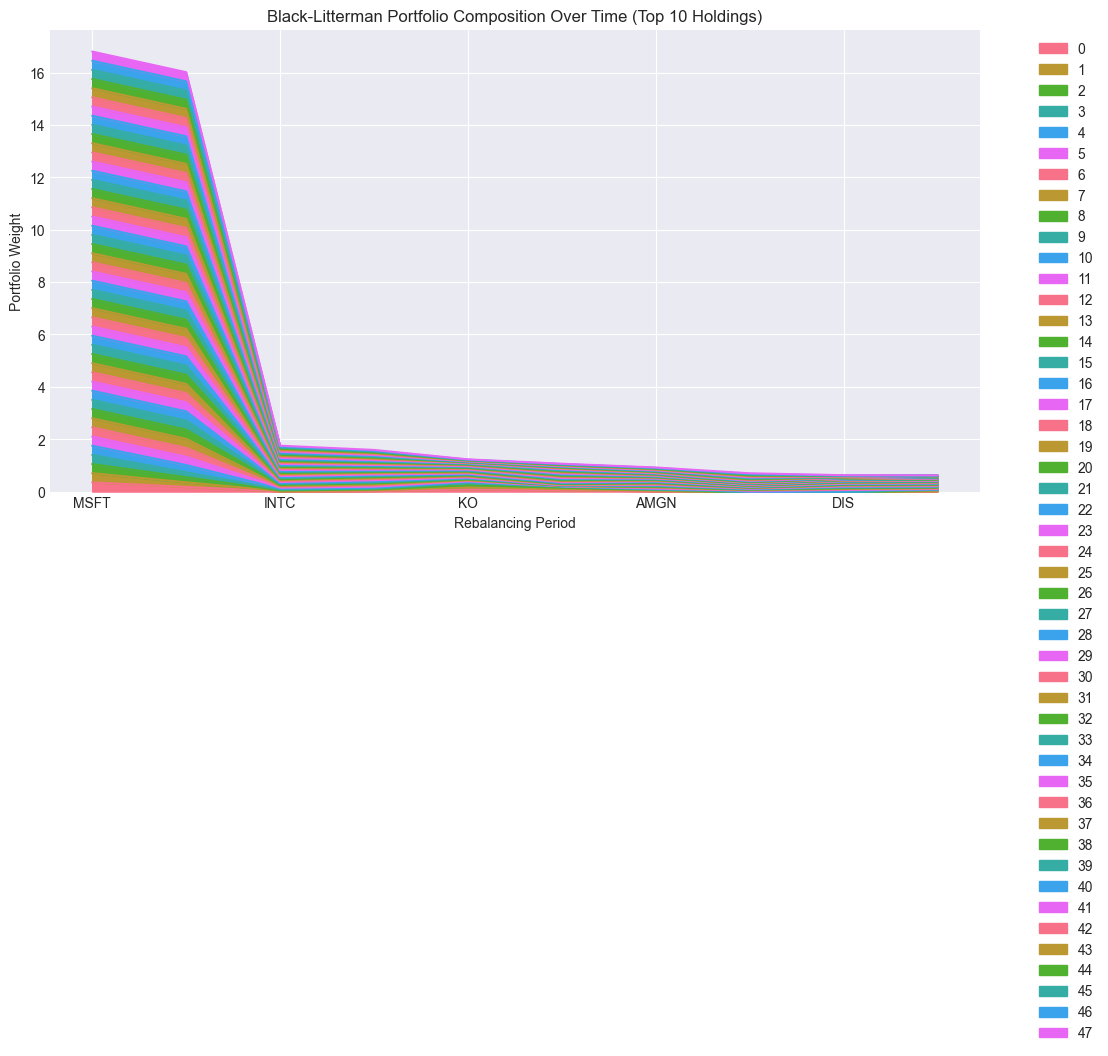

In [96]:
# Visualize how portfolio weights change over time for Black-Litterman
if 'Black-Litterman' in backtest.weights_history:
    bl_weights = pd.DataFrame(backtest.weights_history['Black-Litterman'])
    
    # Select top 10 holdings by average weight
    avg_weights = bl_weights.mean().sort_values(ascending=False)
    top_holdings = avg_weights.head(10).index
    
    # Create stacked area chart
    plt.figure(figsize=(12, 6))
    bl_weights[top_holdings].T.plot(kind='area', stacked=True, figsize=(12, 6))
    plt.title('Black-Litterman Portfolio Composition Over Time (Top 10 Holdings)')
    plt.xlabel('Rebalancing Period')
    plt.ylabel('Portfolio Weight')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

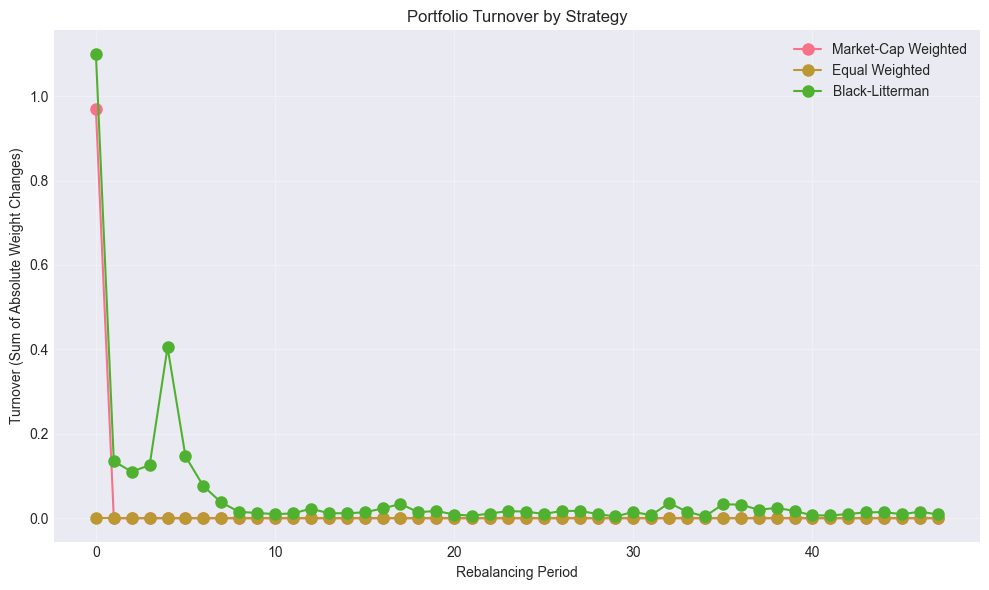


Average Turnover by Strategy:
Market-Cap Weighted: 0.020
Equal Weighted: 0.000
Black-Litterman: 0.057


In [97]:
plt.figure(figsize=(10, 6))
for strategy in backtest.turnover_history:
    if backtest.turnover_history[strategy]:  # Check if not empty
        turnover = pd.Series(backtest.turnover_history[strategy])
        plt.plot(turnover.index, turnover.values, 'o-', label=strategy, markersize=8)

plt.title('Portfolio Turnover by Strategy')
plt.xlabel('Rebalancing Period')
plt.ylabel('Turnover (Sum of Absolute Weight Changes)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nAverage Turnover by Strategy:")
for strategy in backtest.turnover_history:
    if backtest.turnover_history[strategy]:
        avg_turnover = np.mean(backtest.turnover_history[strategy])
        print(f"{strategy}: {avg_turnover:.3f}")

In [98]:
from scipy import stats

if 'Black-Litterman' in backtest.portfolio_values and 'Market-Cap Weighted' in backtest.portfolio_values:
    # Get daily returns
    bl_returns = backtest.portfolio_values['Black-Litterman'].pct_change().dropna()
    market_returns = backtest.portfolio_values['Market-Cap Weighted'].pct_change().dropna()
    
    # Calculate excess returns
    excess_returns = bl_returns - market_returns
    
    # T-test for mean excess return
    t_stat, p_value = stats.ttest_1samp(excess_returns, 0)
    
    print("\n" + "="*60)
    print("STATISTICAL SIGNIFICANCE TEST")
    print("="*60)
    print(f"H0: Black-Litterman returns = Market-Cap returns")
    print(f"Mean excess return: {excess_returns.mean()*252*100:.2f}% annualized")
    print(f"T-statistic: {t_stat:.3f}")
    print(f"P-value: {p_value:.4f}")
    
    if p_value < 0.05:
        print("Result: Black-Litterman significantly outperforms (p < 0.05)")
    else:
        print("Result: No significant difference (p >= 0.05)")
    
    # Information Ratio
    info_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(252)
    print(f"\nInformation Ratio: {info_ratio:.3f}")



STATISTICAL SIGNIFICANCE TEST
H0: Black-Litterman returns = Market-Cap returns
Mean excess return: 2.16% annualized
T-statistic: 2.072
P-value: 0.0383
Result: Black-Litterman significantly outperforms (p < 0.05)

Information Ratio: 0.503


In [43]:
results_df = pd.DataFrame(backtest.portfolio_values)
results_df.to_csv('backtest_results.csv')

# Save final weights
final_weights = {}
for strategy in strategies:
    final_weights[strategy] = strategies[strategy](prices)

final_weights_df = pd.DataFrame(final_weights)
final_weights_df.to_csv('final_portfolio_weights.csv')

print("\nResults saved to:")
print("- backtest_results.csv")
print("- final_portfolio_weights.csv")


Results saved to:
- backtest_results.csv
- final_portfolio_weights.csv
